In [1]:
from dataset import Dataset
import vectorbt as vbt
import numpy as np
import pickle
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
TICKER = 'BTCUSDT'
data_binance = Dataset().get_data(days=360, ticker=TICKER, ts='5m')

In [3]:
with open('data/5m.p', 'rb') as f:
    data_binance = pickle.load(f)

In [4]:
data = data_binance.copy()

In [5]:
data['Middle Band'] = data['close'].rolling(window=50).mean()
data['Upper Band'] = data['Middle Band'] + 1.96*data['close'].rolling(window=50).std()
data['Lower Band'] = data['Middle Band'] - 1.96*data['close'].rolling(window=50).std()

<AxesSubplot:xlabel='time'>

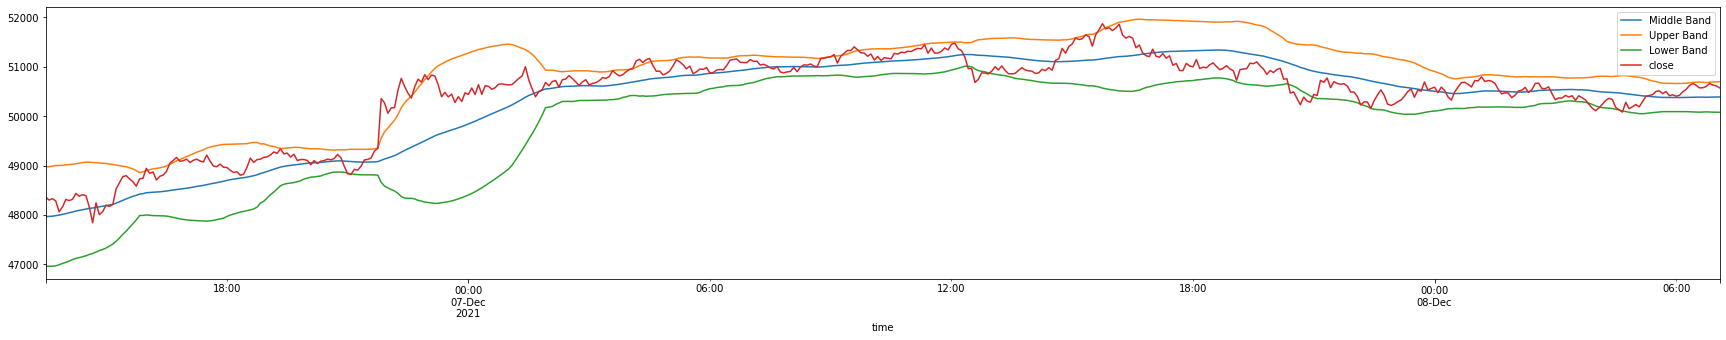

In [7]:
data.tail(500)[['Middle Band', 'Upper Band', 'Lower Band', 'close']].plot(figsize=(30, 5))

In [14]:
best_parameters = []
windows = range(1, 50, 10)
lags = range(1, 50, 10)
trail = [0.001, 0.003, 0.005]
tp_profits = [0.002, 0.004, 0.006, 0.008]
sl_losses = [0.002, 0.004, 0.006, 0.008]

for window in windows:
    for lag in lags:
        for tp in tp_profits:
            for sl in sl_losses:
                for tr in trail:
                    data['Middle Band'] = data['close'].rolling(
                        window=window).mean()
                    data['Upper Band'] = data['Middle Band'] + \
                        1.96*data['close'].rolling(window=window).std()
                    data['Lower Band'] = data['Middle Band'] - \
                        1.96*data['close'].rolling(window=window).std()

                    data['entries_long'] = np.where(
                        data['close'] < data['Lower Band'], True, False)
                    data['exits_long'] = np.where(
                        data['entries_long'].shift(lag), True, False)
                    data['entries_short'] = np.where(
                        data['close'] > data['Upper Band'], True, False)
                    data['exits_short'] = np.where(
                        data['entries_short'].shift(lag), True, False)

                    pf = vbt.Portfolio.from_signals(
                        sl_stop=sl,
                        tp_stop=tp,
                        sl_trail=tr,
                        close=data['close'],
                        entries=data['entries_long'],
                        exits=data['exits_long'],
                        short_entries=data['entries_short'],
                        short_exits=data['exits_short'],
                        direction='both',
                        accumulate=True
                    )
                    stats = pf.stats()
                    if stats['Profit Factor'] > 1.2:
                        print(
                            f'lag: {lag}, window: {window}, sl: {sl}, tp: {tp}, tr: {tr}, return: {stats["Total Return [%]"]}')
                        best_parameters.append({
                            'lag': lag,
                            'window': window,
                            'sl': sl,
                            'tp': tp,
                            'tr': tr,
                            'stat': stats
                        })


lag: 11, window: 11, sl: 0.006, tp: 0.006, tr: 0.001, return: 782.6387952026076
lag: 11, window: 11, sl: 0.006, tp: 0.006, tr: 0.003, return: 782.6387952026076
lag: 11, window: 11, sl: 0.006, tp: 0.006, tr: 0.005, return: 782.6387952026076
lag: 11, window: 11, sl: 0.008, tp: 0.006, tr: 0.001, return: 1055.1132219512701
lag: 11, window: 11, sl: 0.008, tp: 0.006, tr: 0.003, return: 1055.1132219512701
lag: 11, window: 11, sl: 0.008, tp: 0.006, tr: 0.005, return: 1055.1132219512701
lag: 31, window: 11, sl: 0.006, tp: 0.002, tr: 0.001, return: 607.4616889581731
lag: 31, window: 11, sl: 0.006, tp: 0.002, tr: 0.003, return: 607.4616889581731
lag: 31, window: 11, sl: 0.006, tp: 0.002, tr: 0.005, return: 607.4616889581731
lag: 31, window: 11, sl: 0.008, tp: 0.002, tr: 0.001, return: 756.1701355865159
lag: 31, window: 11, sl: 0.008, tp: 0.002, tr: 0.003, return: 756.1701355865159
lag: 31, window: 11, sl: 0.008, tp: 0.002, tr: 0.005, return: 756.1701355865159
lag: 31, window: 11, sl: 0.006, tp: 0

In [18]:
window = 11
lag = 31
sl = 0.008
tp = 0.006
tr = 0.005

data['Middle Band'] = data['close'].rolling(
    window=window).mean()
data['Upper Band'] = data['Middle Band'] + \
    1.96*data['close'].rolling(window=window).std()
data['Lower Band'] = data['Middle Band'] - \
    1.96*data['close'].rolling(window=window).std()

data['entries_long'] = np.where(
    data['close'] < data['Lower Band'], True, False)
data['exits_long'] = np.where(
    data['entries_long'].shift(lag), True, False)
data['entries_short'] = np.where(
    data['close'] > data['Upper Band'], True, False)
data['exits_short'] = np.where(
    data['entries_short'].shift(lag), True, False)

pf = vbt.Portfolio.from_signals(
    sl_stop=sl,
    tp_stop=tp,
    sl_trail=tr,
    close=data['close'],
    entries=data['entries_long'],
    exits=data['exits_long'],
    short_entries=data['entries_short'],
    short_exits=data['exits_short'],
    direction='both',
    accumulate=True
)


In [19]:
pf.stats()

Start                         2020-12-13 00:05:00
End                           2021-12-08 07:05:00
Period                                     103510
Start Value                                 100.0
End Value                             1770.753105
Total Return [%]                      1670.753105
Benchmark Return [%]                   168.297454
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                          19.2965
Max Drawdown Duration                      8372.0
Total Trades                                 4673
Total Closed Trades                          4672
Total Open Trades                               1
Open Trade PnL                           1.729063
Win Rate [%]                            58.069349
Best Trade [%]                           7.306933
Worst Trade [%]                         -5.203676
Avg Winning Trade [%]                     0.61275
Avg Losing Trade [%]                    -0.694708


In [ ]:
pf.plot().show()